In [5]:
!pip install tensorflow
!pip install keras

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.16.1-cp310-cp310-win_amd64.whl (2.1 kB)
Defaulting to user installation because normal site-packages is not writeable


In [64]:
# импорт необходимых библиотек
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
# загрузка данных
way_tr = "train.csv"
way_te = "test.csv"

try:
  if os.path.exists(way_tr) and os.path.exists(way_te):
    train = pd.read_csv(way_tr)
    test = pd.read_csv(way_te)
  print(train)
except Exception as e:
  print(f'Ошибка {e}')

                   id  target
0      gL5fWrgNPU.jpg       0
1      KKWXJDN8uM.png       1
2      Wb2I0CXlAY.jpg       0
3     G7PLhKpaf7.jpeg       1
4      DEUkeefz6Z.jpg       0
...               ...     ...
1007       fqoVycdxLV       1
1008   TN2ZOiNI5e.jpg       0
1009   2WMWt6CAWQ.jpg       0
1010   fQCY5n2vcF.jpg       0
1011       Q9JbpjHZVU       1

[1012 rows x 2 columns]


0    667
1    345
Name: target, dtype: int64


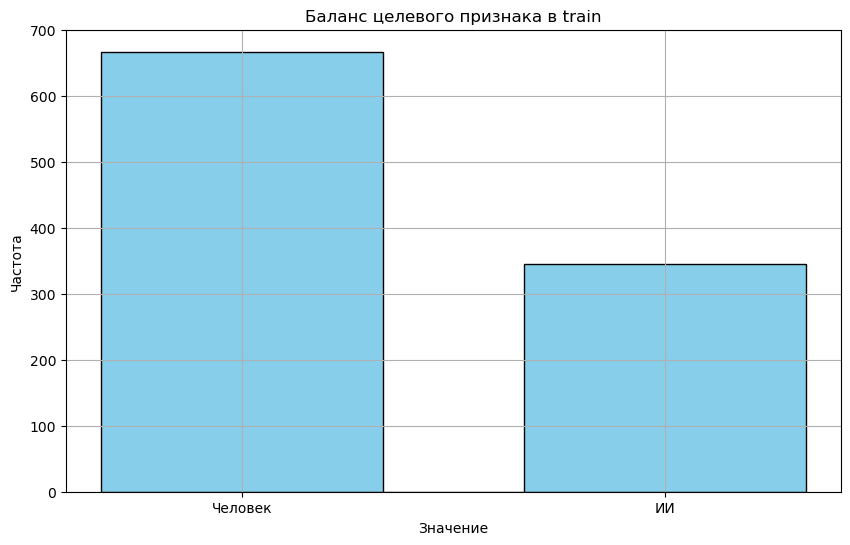

In [8]:
# распределение целевого признака в train
print(train.target.value_counts())


plt.figure(figsize=(10, 6))
plt.hist(train.target, bins=[0, 0.4, 0.6,  1], color='skyblue', edgecolor='black')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Баланс целевого признака в train')
plt.grid(True)
plt.xticks([0.2, 0.8], ['Человек', 'ИИ'])
plt.show()

**Промежуточный вывод**  

Наблюдается явный дизбаланс классов в train. На практике дизбаланс меньший 5:1 не является главной проблемой, так большее значение имеет подбор оптимальной метрики. После обучения базовой модели можно подумать об увеличении объема данных для баланса классов

In [9]:
# проверим наличие изображений в train и test
print(f'Количество изображений присутствующих в train и test одновременно {len(set(train.id) & set(test.id))}')

Количество изображений присутствующих в train и test одновременно 0


In [10]:
# datagen для обработки данных
datagen = ImageDataGenerator(rescale = 1 / 255)

In [11]:
# генератор данных для изображенйи
train_gen_flow = datagen.flow_from_dataframe(
    dataframe = train, 
    directory = r"C:\Users\kil_a\OneDrive\Рабочий стол\Проекты для резюме\Сгенерированные изображения\images",
    x_col = 'id',
    y_col = 'target', 
    target_size = (224, 224),
    batch_size = 32,
    class_mode ='raw',
    seed = 12345)

Found 846 validated image filenames.


C:\Users\kil_a\AppData\Roaming\Python\Python310\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 166 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


In [48]:
# размерность train
train.shape

(1012, 2)

**Промежуточный вывод**  

Ошибка при инициализации генератора данных символизирует о том, что 166 изображений были проигнорированы из-за недействительных имен файлов.Это означает, что у вас есть 1012 действительных изображений, но из-за 166 недействительных имен файлов только 846 изображений загружены в генератор данных

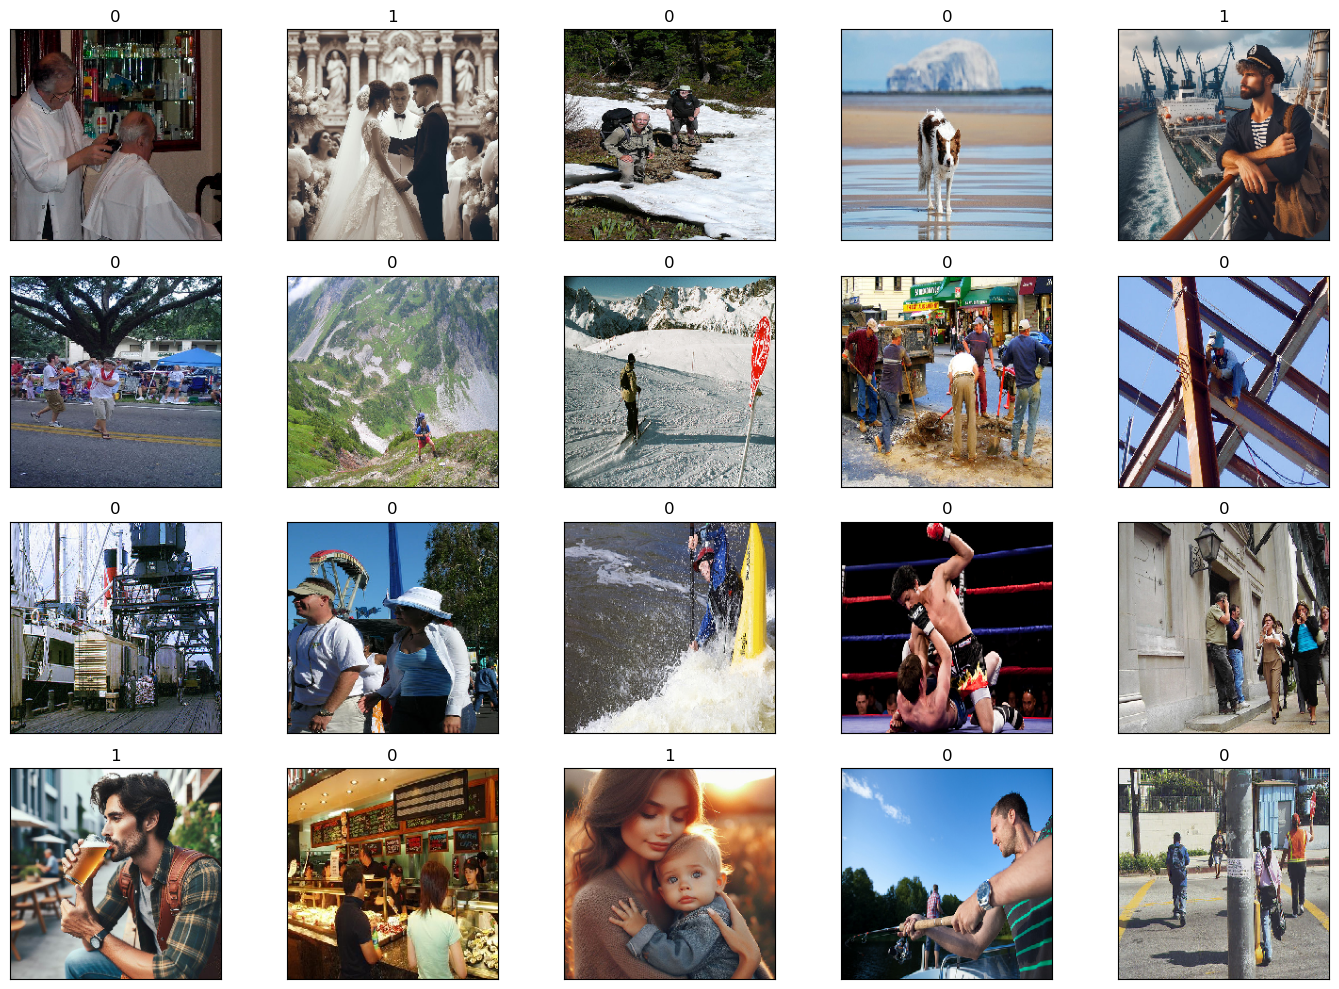

In [12]:
# выведем изображения 
features, target = next(train_gen_flow)
fig = plt.figure(figsize = (15, 10))

for i in range(20):
    fig.add_subplot(4, 5, i + 1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Промежуточный вывод**  

Данные загружены корректно, все фотографии имеют единую концепцию: одинаковый размер, положение предметов и людей, одинаковая ориентация, на выведенных фотографиях отсутствуют дефекты, которые могли бы негативно сказаться на обучении модели

In [117]:
# функция для загрузки тренировочных данных
path = r"C:\Users\kil_a\OneDrive\Рабочий стол\Проекты для резюме\Сгенерированные изображения"
def load_train(path):
    df = pd.read_csv(path + '/train.csv')
    
    train_datagen=ImageDataGenerator(
        rescale=1 / 255,
        horizontal_flip=True, 
    )
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        df, 
        directory = path + '/images',
        x_col = 'id',
        y_col = 'target', 
        target_size = (224, 224), 
        class_mode = 'raw', 
        batch_size = 32, 
        shuffle = True, 
        seed = 12345, 
        subset = 'training'
    )
    return train_gen_flow

train_gen_flow = load_train(path)

images, targets = [], []
for i in range(len(train_gen_flow)):
    features_train, target_train = next(train_gen_flow)
    images.append(features_train)
    targets.append(target_train)
features_train = np.concatenate(images)
target_train = np.concatenate(targets)

num_images_train = features_train.shape[0]

print(f'Количество изображений в features_train: {num_images_train}', end = '. ')
print(f'Потери от предполагаемого объема данных составляют {100 - ((features_train.shape[0]) / train.shape[0]) * 100:.2f}%')

Found 846 validated image filenames.


C:\Users\kil_a\AppData\Roaming\Python\Python310\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 166 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


Количество изображений в features_train: 846. Потери от предполагаемого объема данных составляют 16.40%


In [121]:
# декомпозиция данных
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train,
    target_train,
    test_size=0.2,
    random_state=12345
)
print(f'Размер обучающего набора: {features_train.shape[0]}')
print(f'Размер валидационного набора: {features_valid.shape[0]}')

Размер обучающего набора: 676
Размер валидационного набора: 170


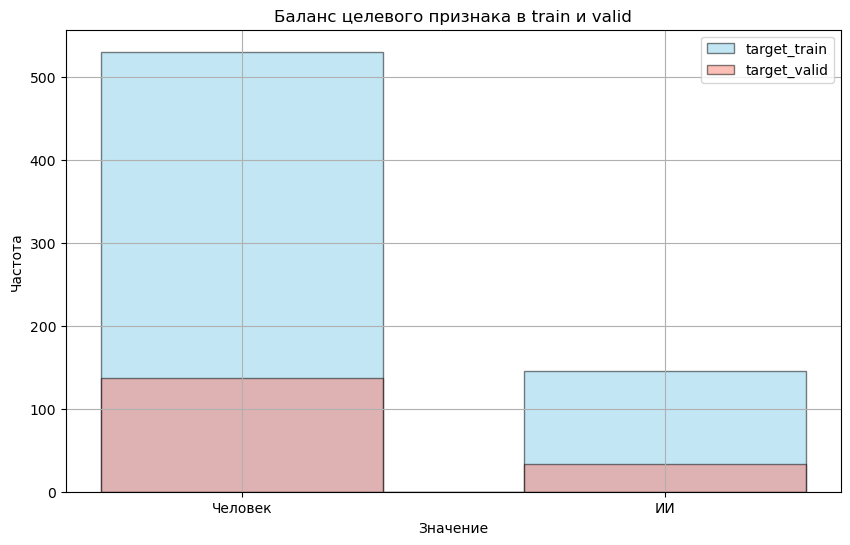

In [122]:
# посмотрим на распределение целевой переменной в train и valid 
plt.figure(figsize=(10, 6))
plt.hist(target_train, bins=[0, 0.4, 0.6, 1], color='skyblue', alpha=0.5, edgecolor='black', label='target_train')
plt.hist(target_valid, bins=[0, 0.4, 0.6, 1], color='salmon', alpha=0.5, edgecolor='black', label='target_valid')

plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Баланс целевого признака в train и valid')
plt.grid(True)
plt.xticks([0.2, 0.8], ['Человек', 'ИИ'])
plt.legend()
plt.show()

In [123]:
# функция для загрузки тестовых данных
path = r"C:\Users\kil_a\OneDrive\Рабочий стол\Проекты для резюме\Сгенерированные изображения"
def load_test(path):
    df = pd.read_csv(path + '/test.csv')
    
    test_datagen=ImageDataGenerator(
        rescale=1 / 255
    )
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        df, 
        directory = path + '/images',
        x_col='id',
        target_size = (224, 224), 
        class_mode = None, 
        batch_size = 32, 
    )
    return test_gen_flow

test_gen_flow = load_test(path)

num_images_test = 0
for _ in test_gen_flow:
    num_images_test += _.shape[0]
    if test_gen_flow.batch_index == 0:
        break

print(f'Количество изображений в features_test: {num_images_test}', end = '. ')
print(f'Потери от предполагаемого объема данных составляют {100 - ((num_images_test) / test.shape[0]) * 100:.2f}%')

Found 421 validated image filenames.


C:\Users\kil_a\AppData\Roaming\Python\Python310\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 85 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


Количество изображений в features_test: 421. Потери от предполагаемого объема данных составляют 16.80%


In [126]:
directory = r"C:\Users\kil_a\OneDrive\Рабочий стол\Проекты для резюме\Сгенерированные изображения\images"
image_names = os.listdir(directory)
img_list = []
for name in image_names:
    img_list.append(name)
print(f'Количество изображений в "images": {len(img_list)}')
print(f'Количество изображений в features_test: {num_images_test}')
print(f'Количество изображений в features_train: {num_images_train}')
print(f'Количество потеряных изображений: {len(img_list) - num_images_test - num_images_train}')

Количество изображений в "images": 1518
Количество изображений в features_test: 421
Количество изображений в features_train: 846
Количество потеряных изображений: 251
